# Week 3 — Immune Gene Drivers of KRAS Co-mutation Context (TCGA LUAD)

**Goal:**
Identify immune genes that distinguish immune-hot KRAS+TP53 tumors from immune-cold KRAS+STK11 and KRAS+KEAP1 tumors.

**Biological question:**
Which immune signaling genes are consistently elevated in KRAS+TP53 tumors relative to both KRAS+STK11 and KRAS+KEAP1 tumors?

**Dataset:**
TCGA LUAD RNA-seq TPM + mutation data

**Author:** Siya Singh


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
maf = pd.read_csv("../data/mc3_LUAD.txt.gz", sep="\t", low_memory=False)
expr = pd.read_csv("../data/TCGA-LUAD.star_tpm.tsv.gz", sep="\t", index_col=0)

# fix gene IDs
expr.index = expr.index.str.split(".").str[0]

gtf = pd.read_csv(
    "../data/gencode.v44.annotation.gtf.gz",
    sep="\t",
    comment="#",
    header=None,
    low_memory=False
)

gtf = gtf[gtf[2]=="gene"]

info = gtf[8]
gene_map = info.str.extract('gene_id "(.*?)";.*gene_name "(.*?)";')
gene_map.columns=["Ensembl","Symbol"]
gene_map["Ensembl"]=gene_map["Ensembl"].str.split(".").str[0]

mapping=dict(zip(gene_map["Ensembl"],gene_map["Symbol"]))

expr["Symbol"]=expr.index.map(mapping)
expr=expr.dropna(subset=["Symbol"])
expr=expr.set_index("Symbol")

# fix sample IDs
expr.columns=[c[:12] for c in expr.columns]

# mutation groups
kras_ids  = set(maf[maf["gene"]=="KRAS"]["sample"].str[:12])
tp53_ids  = set(maf[maf["gene"]=="TP53"]["sample"].str[:12])
stk11_ids = set(maf[maf["gene"]=="STK11"]["sample"].str[:12])
keap1_ids = set(maf[maf["gene"]=="KEAP1"]["sample"].str[:12])

groups={}
for s in kras_ids:
    if s in stk11_ids:
        groups[s]="KRAS+STK11"
    elif s in tp53_ids:
        groups[s]="KRAS+TP53"
    elif s in keap1_ids:
        groups[s]="KRAS+KEAP1"
    else:
        groups[s]="KRAS_only"

samples=[s for s in groups if s in expr.columns]

df=pd.DataFrame({
    "sample":samples,
    "group":[groups[s] for s in samples]
})


In [3]:
df.group.value_counts()

group
KRAS_only     53
KRAS+TP53     46
KRAS+STK11    37
KRAS+KEAP1    14
Name: count, dtype: int64

In [4]:
# extracting samples per group 
tp53_samples  = df[df.group=="KRAS+TP53"].sample
stk11_samples = df[df.group=="KRAS+STK11"].sample
keap1_samples = df[df.group=="KRAS+KEAP1"].sample

In [5]:
tp53_samples  = df[df.group=="KRAS+TP53"]["sample"].tolist()
stk11_samples = df[df.group=="KRAS+STK11"]["sample"].tolist()
keap1_samples = df[df.group=="KRAS+KEAP1"]["sample"].tolist()

In [6]:
# subset expression matrix
expr_tp53  = expr[expr.columns.intersection(tp53_samples)]
expr_stk11 = expr[expr.columns.intersection(stk11_samples)]
expr_keap1 = expr[expr.columns.intersection(keap1_samples)]

In [7]:
# mean expression
mean_tp53  = expr_tp53.mean(axis=1)
mean_stk11 = expr_stk11.mean(axis=1)
mean_keap1 = expr_keap1.mean(axis=1)

In [8]:
diff_tp53_stk11 = mean_tp53 - mean_stk11
diff_tp53_keap1 = mean_tp53 - mean_keap1

In [9]:
common_high = (diff_tp53_stk11 > 0) & (diff_tp53_keap1 > 0)

drivers = diff_tp53_stk11[common_high]
drivers.sort_values(ascending=False).head(20)


Symbol
TNNT1      2.466161
ADGRF1     2.432666
MET        2.243879
CDH3       2.233953
EREG       2.133663
CST6       2.128816
PEG10      2.111642
KCNN4      2.108359
HHLA2      2.043620
AREG       1.839107
TFPI2      1.820386
PLAU       1.787317
COL17A1    1.777110
ZNF486     1.756301
IL37       1.723508
ANXA1      1.708746
CX3CL1     1.591651
CRYBG1     1.587461
IFI44L     1.577465
IVL        1.538481
dtype: float64

In [10]:
immune_keywords = ["CD","HLA","IF","IL","CX","CCL","STAT","IRF","PD","TNF"]

immune_drivers = drivers[
    drivers.index.str.contains("|".join(immune_keywords))
]

immune_drivers.sort_values(ascending=False).head(20)


Symbol
CDH3        2.233953
HHLA2       2.043620
IL37        1.723508
CX3CL1      1.591651
IFI44L      1.577465
IFIT1       1.536606
IFI44       1.463200
CDA         1.435289
HLA-DQA2    1.422338
CXCL10      1.359481
CXCL11      1.315196
CD274       1.267048
IFI6        1.239540
HLA-DQB2    1.225434
CILP        1.204812
CCL28       1.167012
IL36RN      1.156746
CXCL9       1.107332
PDLIM4      1.104240
CXCL14      1.101994
dtype: float64

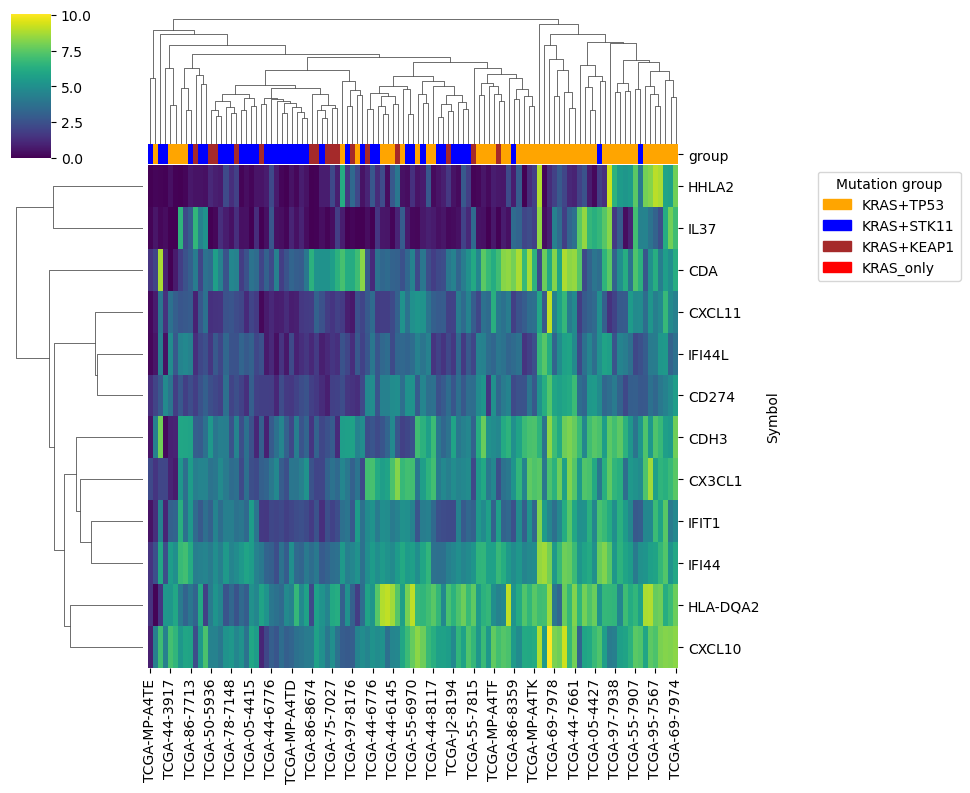

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

top = immune_drivers.sort_values(ascending=False).head(12).index

selected_samples = tp53_samples + stk11_samples + keap1_samples
plot_data = expr.loc[top, expr.columns.intersection(selected_samples)]

# group labels
sample_groups = df.set_index("sample").loc[plot_data.columns]["group"]

# color mapping
group_colors = {
    "KRAS+TP53": "orange",
    "KRAS+STK11": "blue",
    "KRAS+KEAP1": "brown",
    "KRAS_only": "red"
}

col_colors = sample_groups.map(group_colors)

# draw heatmap
g = sns.clustermap(
    plot_data,
    cmap="viridis",
    figsize=(8,8),
    col_colors=col_colors
)

# legend
handles = [Patch(color=color, label=group) for group, color in group_colors.items()]
g.ax_heatmap.legend(
    handles=handles,
    title="Mutation group",
    bbox_to_anchor=(1.25, 1),
    loc="upper left"
)

plt.savefig("../figures/heatmap.png", dpi=300, bbox_inches="tight")

plt.show()


In [12]:
pathways = {
    "Interferon": ["IFI44","IFI44L","IFIT1","IFI6"],
    "Chemokines": ["CXCL9","CXCL10","CXCL11","CX3CL1","CCL28"],
    "Checkpoint": ["CD274","HHLA2"],
    "Antigen": ["HLA-DQA2","HLA-DQB2"]
}


In [13]:
scores = []

group_map = df.set_index("sample")["group"]

for sample in df["sample"]:

    for pname, genes in pathways.items():

        valid = [g for g in genes if g in expr.index]

        if len(valid) == 0:
            continue

        # forcing everything into a numeric flat array
        vals = expr.loc[valid, expr.columns == sample].values.flatten()

        # removing NaNs
        vals = vals[~pd.isna(vals)]

        if len(vals) == 0:
            continue

        score = float(vals.mean())

        scores.append({
            "sample": sample,
            "group": group_map[sample],
            "pathway": pname,
            "score": score
        })

scores = pd.DataFrame(scores)


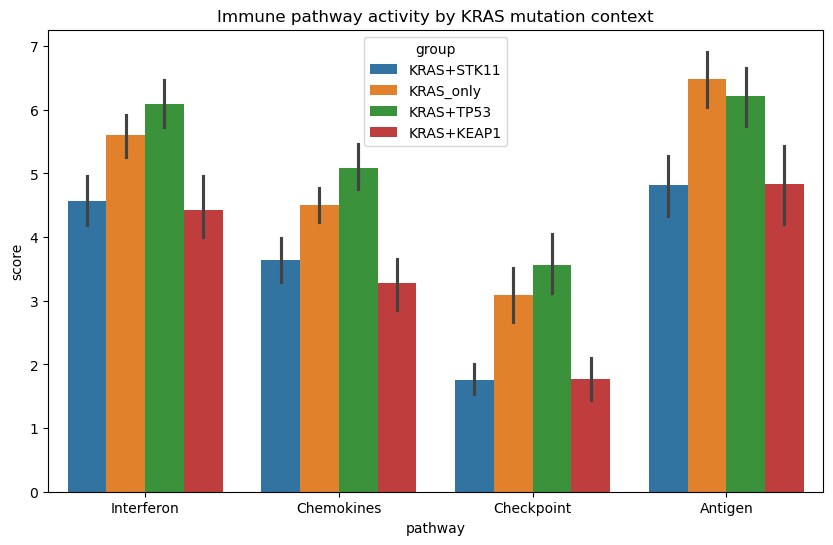

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

sns.barplot(
    data=scores,
    x="pathway",
    y="score",
    hue="group"
)

plt.title("Immune pathway activity by KRAS mutation context")
plt.savefig("../figures/pathway-activity.png", dpi=300, bbox_inches="tight")

plt.show()


In [15]:
from scipy.stats import kruskal

for pathway in scores["pathway"].unique():

    subset = scores[scores["pathway"]==pathway]

    groups = [
        subset[subset.group==g]["score"]
        for g in subset.group.unique()
    ]

    stat, p = kruskal(*groups)

    print(pathway, "p =", p)

Interferon p = 2.077644906038112e-08
Chemokines p = 1.2721827884173766e-08
Checkpoint p = 8.649277389856882e-09
Antigen p = 5.877568451748778e-07


## Conclusion 

In Week 3, I investigated which specific immune genes and transcriptional programs account for the immune differences observed between KRAS co-mutation contexts in TCGA lung adenocarcinoma.

Tumors were stratified into KRAS+TP53, KRAS+STK11, KRAS+KEAP1, and KRAS-only groups, and gene-level expression comparisons were performed to identify immune genes enriched in each context. KRAS+TP53 tumors showed increased expression of multiple immune-related genes, including interferon-stimulated genes (e.g., IFI family members), chemokines associated with cytotoxic T-cell recruitment (CXCL9, CXCL10, CXCL11, CX3CL1), antigen presentation genes (HLA class II genes), and immune checkpoint ligands such as CD274 (PD-L1).

To determine whether these differences reflected coordinated immune programs rather than isolated gene effects, pathway-level activity scores were calculated for interferon signaling, chemokine recruitment, antigen presentation, and checkpoint pathways. Across all four pathways, KRAS+TP53 tumors consistently exhibited higher transcriptional activity compared with KRAS+STK11 and KRAS+KEAP1 tumors, indicating a more immune-inflamed transcriptional phenotype.

Statistical validation using Kruskal–Wallis tests confirmed that immune pathway activity differed significantly across mutation contexts for all pathways examined (p < 10⁻⁶). Principal component analysis using immune driver genes further demonstrated that mutation context contributes to variation in immune transcription, although substantial heterogeneity remains across tumors, consistent with known complexity in human cancer transcriptomes.

Overall, these findings indicate that immune differences among KRAS-mutant lung tumors are associated with coordinated activation of interferon signaling, chemokine recruitment, antigen presentation, and checkpoint pathways in TP53-co-mutant tumors, while STK11 and KEAP1 co-mutations are associated with comparatively reduced immune transcriptional activity. This analysis highlights the importance of genomic context in shaping tumor immune programs and demonstrates how public cancer genomics datasets can be used to investigate mutation-specific immune biology.